# Dogs V.S. Cats
## Environment Configuration

In [1]:
!kaggle competitions download -c dogs-vs-cats

dogs-vs-cats.zip: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
!unzip -q -n dogs-vs-cats.zip


In [3]:
!unzip -q -n train.zip

## Build Custom Dataset

In [4]:
import os, shutil, pathlib

In [5]:
original_dir = pathlib.Path('train')
new_base_dir = pathlib.Path('cats_vs_dogs_small')

def make_subset(subset_name, start_index, end_index):
    for category in ('cat', 'dog'):
        dir = new_base_dir / subset_name / category
        try:
            os.makedirs(dir)
        except FileExistsError:
            return
        fnames = [f"{category}.{i}.jpg"
                  for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname, dst=dir / fname)

make_subset('train', 0, 1000)
make_subset('validation', 1000, 1500)
make_subset('test', 1500, 2500)

## Building the model

In [6]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

In [7]:
inputs= keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

In [8]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [9]:
from tensorflow.keras.utils import image_dataset_from_directory

In [10]:
train_dataset = image_dataset_from_directory(
    directory=new_base_dir / 'train',
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    directory=new_base_dir / 'validation',
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    directory=new_base_dir / 'test',
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [11]:
for data_batch, labels_batch in train_dataset:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


2025-06-04 00:08:10.925013: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2025-06-04 00:08:10.926859: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [12]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='convnet_from_scratch.keras',
        save_best_only=True,
        monitor='val_loss')
]

In [13]:
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 21s 331ms/step - loss: 0.7568 - accuracy: 0.5040 - val_loss: 0.6985 - val_accuracy: 0.5000
Epoch 2/30
63/63 [==============================] - 21s 328ms/step - loss: 0.7056 - accuracy: 0.5290 - val_loss: 0.6897 - val_accuracy: 0.5110
Epoch 3/30
63/63 [==============================] - 20s 323ms/step - loss: 0.6982 - accuracy: 0.5830 - val_loss: 0.6383 - val_accuracy: 0.6370
Epoch 4/30
63/63 [==============================] - 21s 340ms/step - loss: 0.6543 - accuracy: 0.6380 - val_loss: 0.6677 - val_accuracy: 0.5980
Epoch 5/30
63/63 [==============================] - 21s 330ms/step - loss: 0.6054 - accuracy: 0.6760 - val_loss: 0.6017 - val_accuracy: 0.6700
Epoch 6/30
63/63 [==============================] - 20s 320ms/step - loss: 0.5725 - accuracy: 0.7160 - val_loss: 0.7859 - val_accuracy: 0.6140
Epoch 7/30
63/63 [==============================] - 20s 319ms/step - loss: 0.5258 - accuracy: 0.7360 - val_loss: 0.5959 - val_accuracy: 0.6830

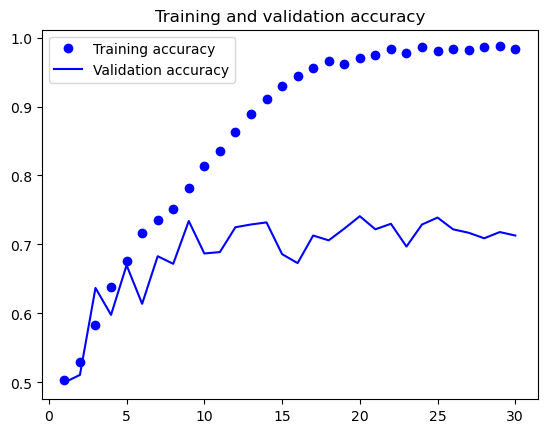

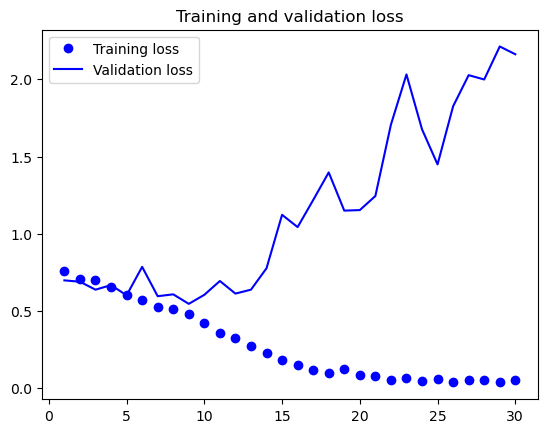

In [14]:
import matplotlib.pyplot as plt
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [15]:
test_model = keras.models.load_model('convnet_from_scratch.keras')
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f'Test accuracy: {test_acc:.2f}')

63/63 [==============================] - 6s 88ms/step - loss: 0.5866 - accuracy: 0.7230
Test accuracy: 0.72


### Using Data Augmenmtation

In [16]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

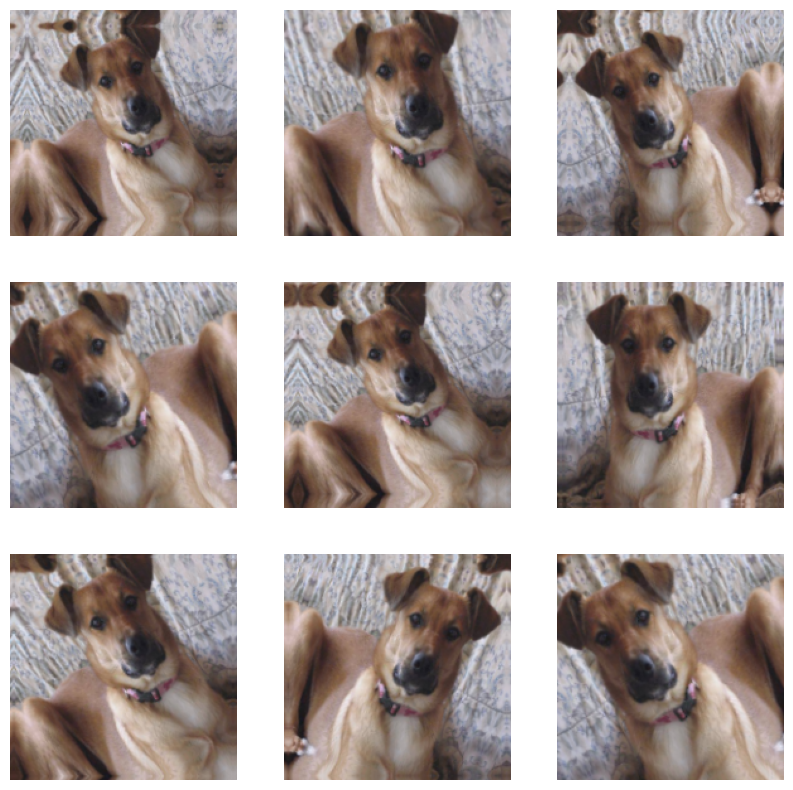

In [17]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8")) 
        plt.axis("off")

In [18]:
inputs= keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

In [19]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [20]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='convnet_from_scratch_with_augmentation.keras',
        save_best_only=True,
        monitor='val_loss')
]

In [21]:
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
63/63 [==============================] - 23s 359ms/step - loss: 0.7345 - accuracy: 0.5030 - val_loss: 0.6917 - val_accuracy: 0.5010
Epoch 2/100
63/63 [==============================] - 21s 331ms/step - loss: 0.7070 - accuracy: 0.5310 - val_loss: 0.6859 - val_accuracy: 0.5120
Epoch 3/100
63/63 [==============================] - 21s 335ms/step - loss: 0.6945 - accuracy: 0.5635 - val_loss: 0.6708 - val_accuracy: 0.5900
Epoch 4/100
63/63 [==============================] - 21s 340ms/step - loss: 0.6791 - accuracy: 0.5865 - val_loss: 0.6737 - val_accuracy: 0.5840
Epoch 5/100
63/63 [==============================] - 21s 333ms/step - loss: 0.6690 - accuracy: 0.6125 - val_loss: 0.6309 - val_accuracy: 0.6290
Epoch 6/100
63/63 [==============================] - 21s 333ms/step - loss: 0.6471 - accuracy: 0.6375 - val_loss: 0.6139 - val_accuracy: 0.6720
Epoch 7/100
63/63 [==============================] - 21s 338ms/step - loss: 0.6180 - accuracy: 0.6780 - val_loss: 0.6216 - val_accuracy:

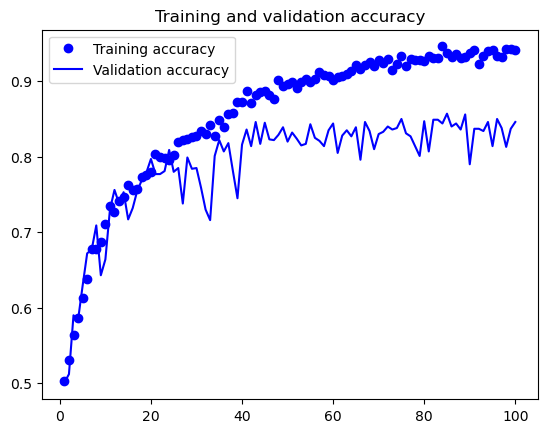

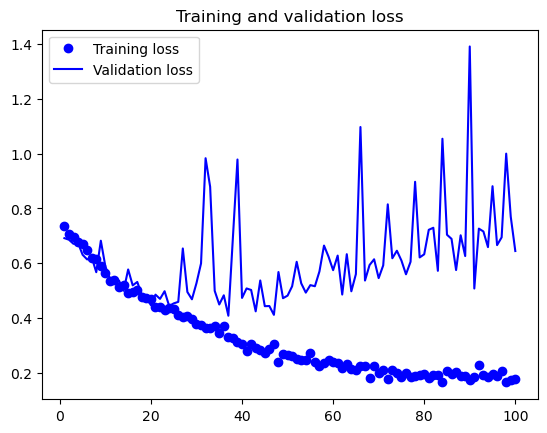

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [23]:
test_model = keras.models.load_model('convnet_from_scratch_with_augmentation.keras')
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f'Test accuracy: {test_acc:.2f}')

63/63 [==============================] - 5s 85ms/step - loss: 0.4561 - accuracy: 0.8055
Test accuracy: 0.81


# Leveraging Pretrained Model


In [24]:
conv_base = keras.applications.VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(180, 180, 3))

In [25]:
import numpy as np

def get_feature_and_labels(datasets):
    all_features = []
    all_labels = []
    for images, labels in datasets:
        preprocess_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocess_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

In [26]:
train_features, train_labels = get_feature_and_labels(train_dataset)
val_features, val_labels = get_feature_and_labels(validation_dataset)
test_features, test_labels = get_feature_and_labels(test_dataset)

In [27]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

In [28]:
model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

In [29]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='feature_extraction.keras',
        save_best_only=True,
        monitor='val_loss'
    )
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 1s 9ms/step - loss: 18.2925 - accuracy: 0.9240 - val_loss: 3.6957 - val_accuracy: 0.9700
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 4.2697 - accuracy: 0.9705 - val_loss: 4.0456 - val_accuracy: 0.9690
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 1.3058 - accuracy: 0.9905 - val_loss: 5.5825 - val_accuracy: 0.9720
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 2.0977 - accuracy: 0.9870 - val_loss: 3.8871 - val_accuracy: 0.9770
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 1.0607 - accuracy: 0.9915 - val_loss: 5.7163 - val_accuracy: 0.9690
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 1.9180 - accuracy: 0.9915 - val_loss: 9.8146 - val_accuracy: 0.9670
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 0.6551 - accuracy: 0.9950 - val_loss: 9.9232 - val_accuracy: 0.9680
Epoch 8/20
63/63 [=

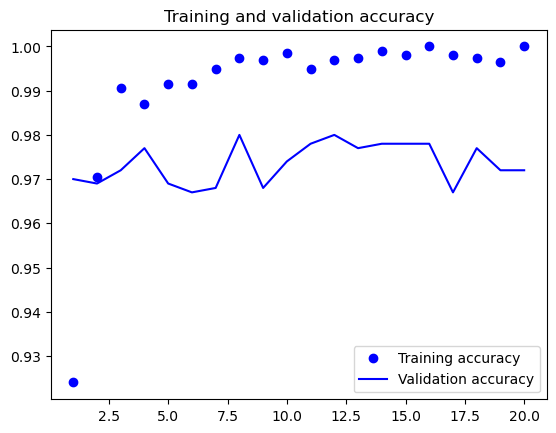

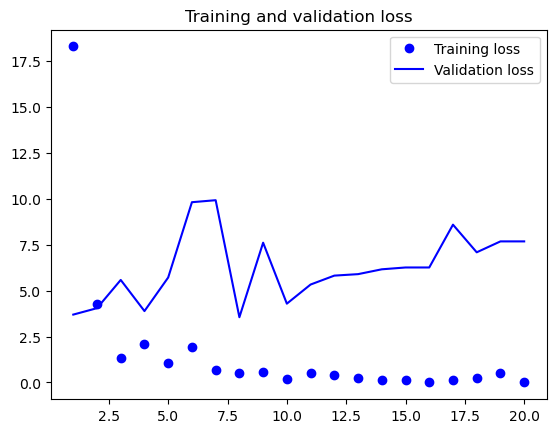

In [30]:
import matplotlib.pyplot as plt
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Feature Extraction

In [31]:
conv_base = keras.applications.VGG16(
    weights='imagenet',
    include_top=False)
conv_base.trainable = False
print('This is the number of trainable weights '
        'after freezing the conv base:', len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


In [32]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [33]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

In [34]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss",
    )
]

In [40]:
history = model.fit(
        train_dataset,
        epochs=50,
        validation_data=validation_dataset,
        callbacks=callbacks
    )

Epoch 1/50
63/63 [==============================] - 145s 2s/step - loss: 18.0459 - accuracy: 0.9060 - val_loss: 5.6004 - val_accuracy: 0.9600
Epoch 2/50
63/63 [==============================] - 154s 2s/step - loss: 7.2210 - accuracy: 0.9435 - val_loss: 5.7892 - val_accuracy: 0.9610
Epoch 3/50
63/63 [==============================] - 137s 2s/step - loss: 6.3528 - accuracy: 0.9485 - val_loss: 5.0188 - val_accuracy: 0.9750
Epoch 4/50
63/63 [==============================] - 132s 2s/step - loss: 5.3941 - accuracy: 0.9580 - val_loss: 7.9384 - val_accuracy: 0.9590
Epoch 5/50
63/63 [==============================] - 137s 2s/step - loss: 4.5724 - accuracy: 0.9585 - val_loss: 6.9714 - val_accuracy: 0.9640
Epoch 6/50
63/63 [==============================] - 136s 2s/step - loss: 4.3399 - accuracy: 0.9670 - val_loss: 5.2281 - val_accuracy: 0.9760
Epoch 7/50
63/63 [==============================] - 140s 2s/step - loss: 2.9033 - accuracy: 0.9695 - val_loss: 6.1407 - val_accuracy: 0.9660
Epoch 8/50
6

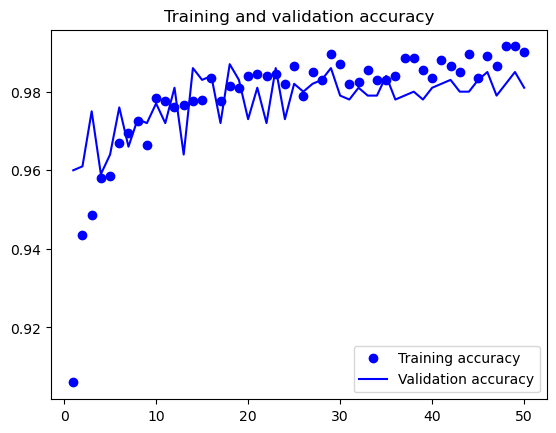

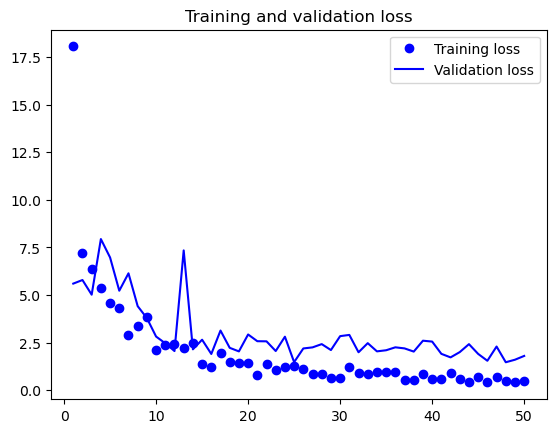

In [41]:
import matplotlib.pyplot as plt
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()